In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
data = pd.read_csv('C:/Users/yugeng/Desktop/基于adaboost隐私保护的车联网轨迹预测系统/实验/energydata_complete.csv')
data.head(2)

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.7900,19.79,44.73,19.0,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.7225,19.79,44.79,19.0,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195


In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
data.drop("date",axis=1,inplace=True)
dataset = data.values.astype('float32')

scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

In [3]:
dataset.shape

(19735, 28)

In [4]:
dataset[0,0]

0.046728972

In [5]:
def split_train_test(dataset,test_ratio):
    """
    :param dataset:
    :param test_ratio:
    :return:
    """
    test_set_size = int((len(dataset)) * test_ratio)
    return dataset[:test_set_size],dataset[test_set_size:]

In [6]:
# 创建数据集
tatio = 0.5
train,validation = split_train_test(dataset,tatio)

In [7]:
train.shape

(9867, 28)

In [8]:
type(train)

numpy.ndarray

In [9]:
validation.shape

(9868, 28)

In [29]:
# (-1,36,28)  -1,6,28
# test (-1,36,28)   (-1,6) 
def create_dataset(dataset,a_look_back,b_look_back):  
    dataX, dataY = [], []
    total_look_back=(a_look_back+b_look_back)
    for i in range(int(len(dataset)/total_look_back)):
        x = dataset[total_look_back*i:total_look_back*i+a_look_back,:]
        dataX.append(x)
        y = dataset[total_look_back*i+a_look_back:total_look_back*(i+1),0]
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
train_X,train_Y = create_dataset(train,36,6)
validation_X,validation_Y = create_dataset(validation,36,6)
print(train_X.shape)
print(validation_Y.shape)

(234, 36, 28)
(234, 6)


In [30]:
from keras import backend as K
def rmse(y_true, y_pred):  
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [31]:
# model
from keras import Input , layers
from keras.models import Model
import keras.optimizers
def create_model(time_step=36,input_n_size=28):
    seed=10
    np.random.seed(seed)
    encoder_LSTM_units=128
    encoder_inputs = Input(shape=(time_step, input_n_size),name="encoder_inputs_x")
    #encoder = layers.LSTM(encoder_LSTM_units,return_sequences=True,name="encoder_LSTM")
    encoder = layers.LSTM(encoder_LSTM_units,name="encoder_LSTM")
    outputs = encoder(encoder_inputs)
    dense = layers.Dense(6,activation=None)
    decoder_outputs = dense(outputs)
    model = Model(
        inputs=encoder_inputs,
        outputs=decoder_outputs
    )
    # 编译model
    #RMSprop = keras.optimizers.rmsprop_v2(lr=0.001)
    model.compile(loss='mse', optimizer="RMSprop",metrics=['mae',rmse])
    # 打印model 结构
    print(model.summary())
    return model

In [32]:
model = create_model()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs_x (InputLaye  [(None, 36, 28)]         0         
 r)                                                              
                                                                 
 encoder_LSTM (LSTM)         (None, 128)               80384     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 81,158
Trainable params: 81,158
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
history = model.fit(train_X,train_Y,
                    batch_size=1, epochs=1, verbose=1,
                    validation_data=(validation_X,validation_Y))

234/234 [==============================] - 3s 11ms/step - loss: 0.0089 - mae: 0.0583 - rmse: 0.0721 - val_loss: 0.0140 - val_mae: 0.0836 - val_rmse: 0.1043


In [36]:
start = time.time()
predict_X = model.predict(validation_X,batch_size=1,verbose=1)
end = time.time()
print(end-start)

234/234 [==============================] - 1s 4ms/step
1.0445618629455566


In [16]:
predict_X.shape

(234, 6)

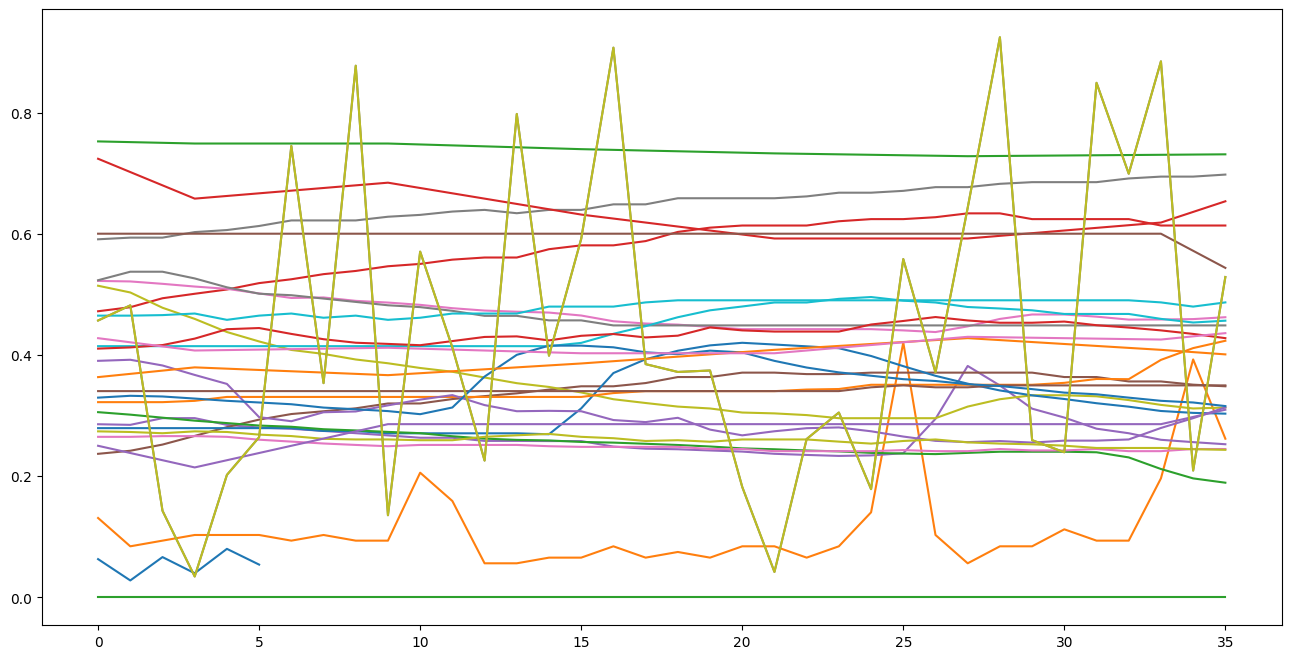

In [17]:
plt.figure(figsize=(16,8))
plt.plot(predict_X[0], label="True value")
plt.plot(validation_X[1], label="Pred value")
plt.show()